In [ ]:
import numpy as np
import pandas as pd

# -----------------------------
# Metric functions (as given)
# -----------------------------
def nse(obs: np.ndarray, sim: np.ndarray) -> float:
    m = np.nanmean(obs)
    denom = np.nansum((obs - m) ** 2)
    if denom == 0 or np.isnan(denom):
        return np.nan
    return 1.0 - np.nansum((sim - obs) ** 2) / denom

def nnse(obs, sim):
    v = nse(obs, sim)
    return np.nan if np.isnan(v) else 1.0 / (2.0 - v)

def mse(obs, sim):
    return np.nanmean((sim - obs) ** 2)

def mae(obs, sim):
    return np.nanmean(np.abs(sim - obs))

def kge(obs, sim) -> float:
    obs_m, sim_m = np.nanmean(obs), np.nanmean(sim)
    obs_s, sim_s = np.nanstd(obs, ddof=0), np.nanstd(sim, ddof=0)
    valid = np.isfinite(obs) & np.isfinite(sim)
    if valid.sum() < 2 or obs_s == 0 or np.isnan(obs_m) or np.isnan(sim_m):
        return np.nan
    r = np.corrcoef(obs[valid], sim[valid])[0, 1]
    beta = np.nan if obs_m == 0 else sim_m / obs_m
    gamma = np.nan if (sim_m == 0 or obs_m == 0 or obs_s == 0) else (sim_s / sim_m) / (obs_s / obs_m)
    if np.isnan(r) or np.isnan(beta) or np.isnan(gamma):
        return np.nan
    return 1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2)

def mape(obs, sim):
    valid = np.isfinite(obs) & np.isfinite(sim) & (obs != 0)
    return np.nanmean(np.abs((sim[valid] - obs[valid]) / obs[valid])) * 100

def rnse(obs, sim):
    # normalized NSE (divides by sum of obs^2)
    denom = np.nansum(obs ** 2)
    if denom == 0 or np.isnan(denom):
        return np.nan
    return 1.0 - np.nansum((sim - obs) ** 2) / denom

def rmae(obs, sim):
    valid = np.isfinite(obs) & np.isfinite(sim) & (obs != 0)
    return np.nanmean(np.abs((sim[valid] - obs[valid]) / obs[valid])) * 100  # now %

def nrmse(obs, sim):
    rmse = np.sqrt(np.nanmean((sim - obs) ** 2))
    obs_range = np.nanmax(obs) - np.nanmin(obs)
    return (rmse / obs_range) * 100 if obs_range != 0 else np.nan  # now %



METRIC_FUNS = {
    "NSE": nse,
    "NNSE": nnse,
    "MSE": mse,
    "MAE": mae,
    "KGE": kge,
    "rNSE": rnse,
    "rMAE": rmae,
    "MAPE (%)": mape,
    "NRMSE": nrmse
}


# -----------------------------
# Configuration
# -----------------------------
file_path = "for_scatterplot.xlsx"

OBS_COLUMN = "Qm (Thebes)"  

SIM_COLUMN = "Qnew"

def compute_metrics(obs: pd.Series, sim: pd.Series) -> dict:
    data = pd.concat([obs, sim], axis=1).dropna()
    if data.empty:
        return {k: np.nan for k in METRIC_FUNS} | {"N": 0}

    o = data.iloc[:, 0].to_numpy()
    s = data.iloc[:, 1].to_numpy()
    metrics = {name: func(o, s) for name, func in METRIC_FUNS.items()}
    metrics["N"] = len(data)
    return metrics

# --------------------------------------------------
# Process all sheets
# --------------------------------------------------
xls = pd.ExcelFile(file_path)
results = []

for sheet in xls.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    if OBS_COLUMN not in df.columns or SIM_COLUMN not in df.columns:
        print(f"Skipping '{sheet}' (columns missing)")
        continue

    metrics = compute_metrics(df[OBS_COLUMN], df[SIM_COLUMN])
    results.append({"Sheet": sheet} | metrics)

# --------------------------------------------------
# Create summary table
# --------------------------------------------------
summary = pd.DataFrame(results)
pd.set_option("display.max_columns", None)
print(summary)

# Optionally save to Excel
output_file = "model_metrics_summary.xlsx"
summary.to_excel(output_file, index=False)
print(f"\nSaved metrics to: {output_file}")

      Sheet       NSE      NNSE           MSE          MAE       KGE  \
0  Method_1  0.999746  0.999746  7.455896e+06  1825.262622  0.993740   
1  Method_2  0.999084  0.999085  2.684756e+07  4562.601232  0.981294   
2  Method_3  0.999800  0.999800  5.869410e+06  1875.320824  0.993476   

       rNSE      rMAE  MAPE (%)     NRMSE       N  
0  0.999928  0.694202  0.694202  0.312742  106822  
1  0.999740  1.975157  1.975157  0.593456  106822  
2  0.999943  0.792286  0.792286  0.277481  106822  

Saved metrics to: model_metrics_summary.xlsx


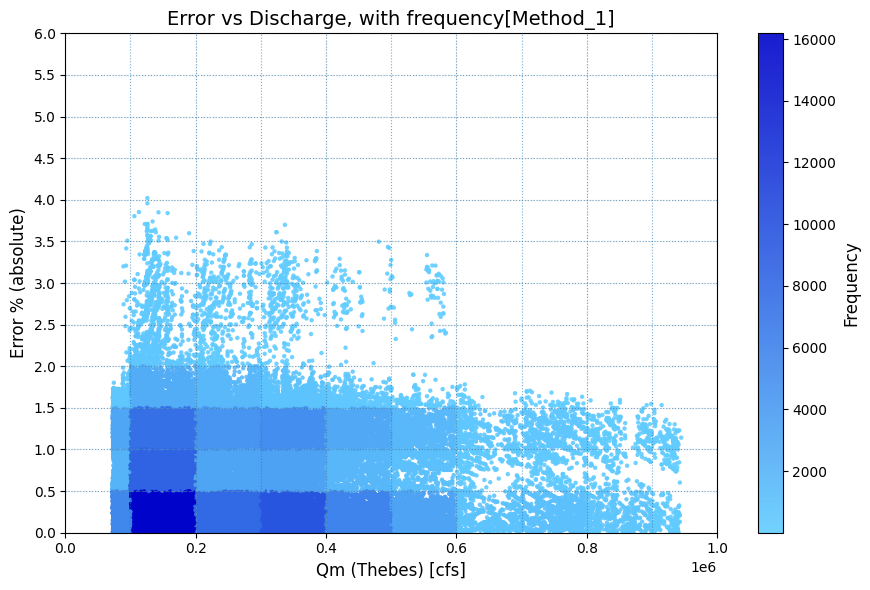

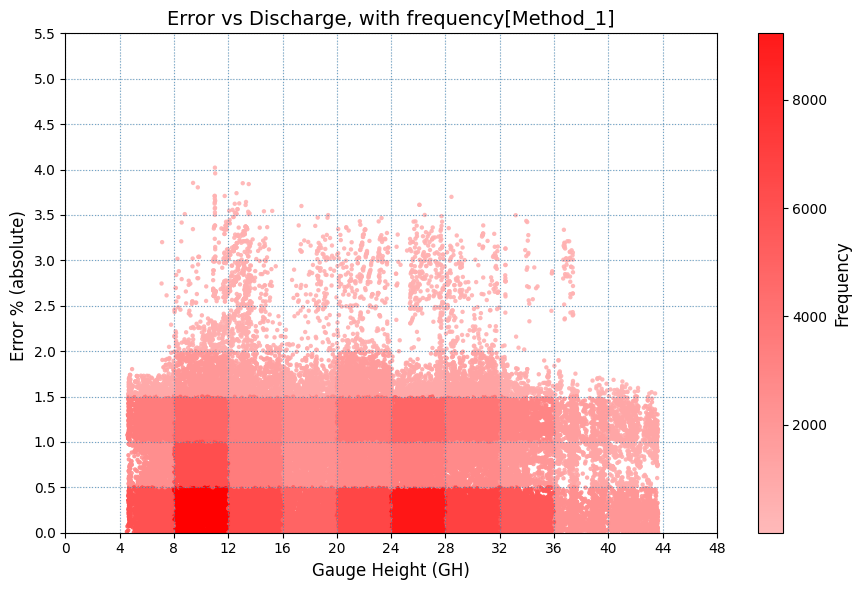

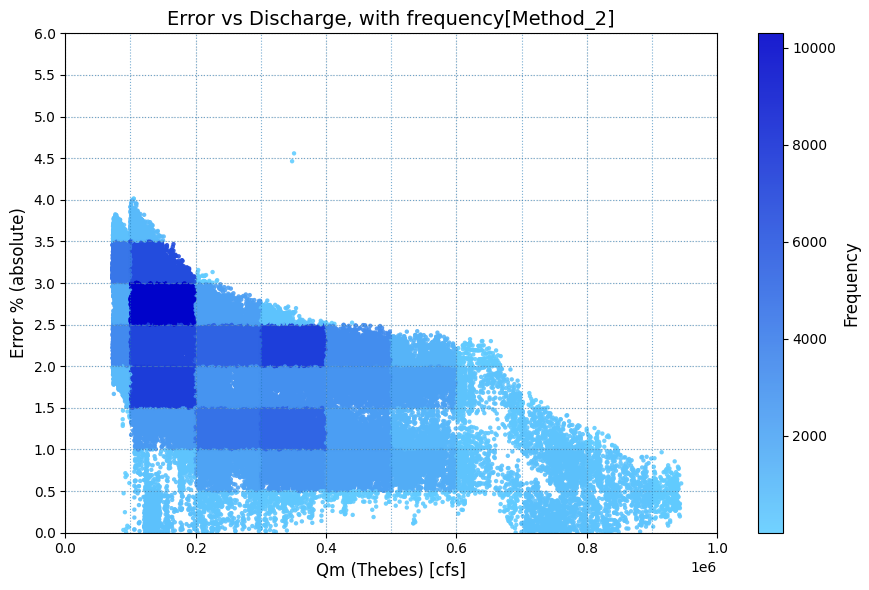

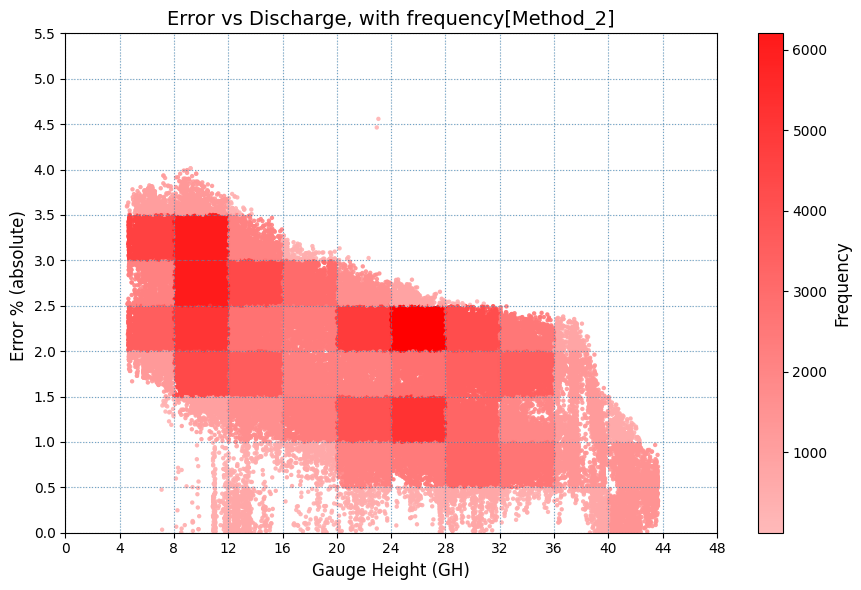

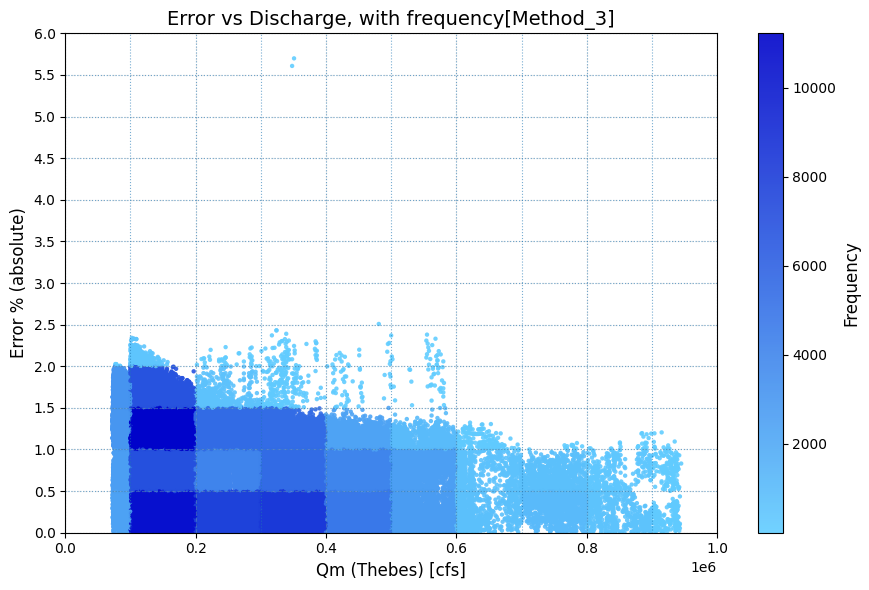

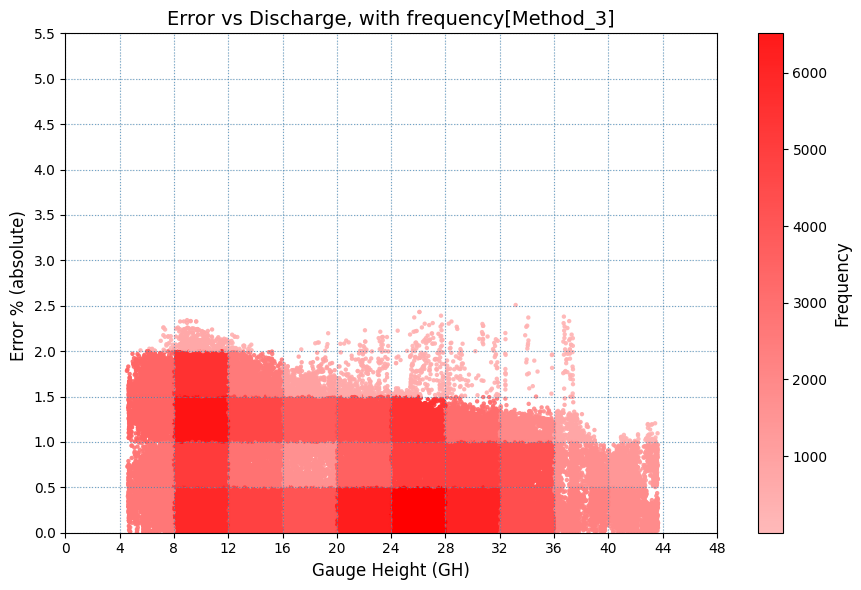

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap  # for white→red

file_path = "for_scatterplot.xlsx"
SHEETS = ["Method_1", "Method_2", "Method_3"]



# White→red colormap
Blue_hue = LinearSegmentedColormap.from_list("Blue_hue", ["#62CDFF", "#0003ca"])
Red_hue = LinearSegmentedColormap.from_list("Red_hue", ["#FFB2B2", "#FF0000"])

def scatter_colored_by_bin_frequency(df, sheet_name):

    # X bins: 0–100k, …, 900k–1,000k
    x_edges = np.arange(0, 1_000_000 + 100_000, 100_000)

    # Y bins: 0–0.5, 0.5–1.0, … up to a cap (adjust if you want taller)
    y_step = 0.5  # percent
    y_max_cap = 6.0  # make this bigger if needed
    y_edges = np.arange(0.0, y_max_cap + y_step, y_step)

    # Keep only required columns, drop NaNs
    data = df[["Qm (Thebes)", "Error % (absolute)"]].dropna().copy()

    # Optionally clip to the defined bin ranges so everything maps to a bin
    data["Qm (Thebes)"] = data["Qm (Thebes)"].clip(x_edges[0], x_edges[-1])
    data["Error % (absolute)"] = data["Error % (absolute)"].clip(y_edges[0], y_edges[-1])

    x = data["Qm (Thebes)"].to_numpy()
    y = data["Error % (absolute)"].to_numpy()

    # Map each point to a bin index
    # np.digitize returns 1..len(edges)-1 for inside, so subtract 1 for 0-based
    ix = np.digitize(x, x_edges) - 1
    iy = np.digitize(y, y_edges) - 1

    # Keep only points that fell inside both axes (0..n_bins-1)
    mask = (ix >= 0) & (ix < len(x_edges) - 1) & (iy >= 0) & (iy < len(y_edges) - 1)
    ix, iy = ix[mask], iy[mask]
    x, y = x[mask], y[mask]

    # Build 2D counts per bin
    counts = np.zeros((len(x_edges) - 1, len(y_edges) - 1), dtype=int)
    np.add.at(counts, (ix, iy), 1)

    # Color for each dot is the count in its bin
    c = counts[ix, iy]

    # Plot
    plt.figure(figsize=(9, 6))
    sc = plt.scatter(
        x, y,
        c=c,
        cmap=Blue_hue,    # white to red, red = higher frequency
        s=10,                 # dot size, tweak if needed
        alpha=0.9,
        edgecolors="none"
    )

    # Gridlines at bin edges
    for xe in x_edges:
        plt.axvline(x=xe, linestyle=":", linewidth=0.8, alpha=0.6)
    for ye in y_edges:
        plt.axhline(y=ye, linestyle=":", linewidth=0.8, alpha=0.6)

    # Labels and title
    plt.xlabel("Qm (Thebes) [cfs]", fontsize=12)
    plt.ylabel("Error % (absolute)", fontsize=12)
    plt.title(f"Error vs Discharge, with frequency[{sheet_name}]", fontsize=14)

    # Axis limits to the bin ranges
    plt.xlim(x_edges[0], x_edges[-1])
    plt.ylim(y_edges[0], y_edges[-1])

    # Lighter grid behind
    plt.grid(True, linestyle="--", alpha=0.3)

    # Colorbar shows frequency per bin
    cbar = plt.colorbar(sc)
    cbar.set_label("Frequency", fontsize=12)

    # Optional: thin ticks so they do not clutter
    plt.xticks(x_edges[::2])  # every 200k
    plt.yticks(y_edges)       # every 0.5%

    plt.tight_layout()
    plt.show()
############################################################################

    # X bins: 0–xmax
    y_edges = np.arange(0, 6, 0.5)

    # Y bins: 0–0.5, 0.5–1.0, … up to a cap (adjust if you want taller)
    x_step = 4.0  # percent
    x_max_cap = 45.0  # make this bigger if needed
    x_edges = np.arange(0.0, x_max_cap + x_step, x_step)

    data = df[["Error % (absolute)", "Gauge Height (GH)"]].dropna().copy()

    # Optionally clip to the defined bin ranges so everything maps to a bin
    data["Error % (absolute)"] = data["Error % (absolute)"].clip(y_edges[0], y_edges[-1])
    data["Gauge Height (GH)"] = data["Gauge Height (GH)"].clip(x_edges[0], x_edges[-1])

    y = data["Error % (absolute)"].to_numpy()
    x = data["Gauge Height (GH)"].to_numpy()

    # Map each point to a bin index
    # np.digitize returns 1..len(edges)-1 for inside, so subtract 1 for 0-based
    iy = np.digitize(y, y_edges) - 1
    ix = np.digitize(x, x_edges) - 1

    # Keep only points that fell inside both axes (0..n_bins-1)
    mask = (iy >= 0) & (iy < len(y_edges) - 1) & (ix >= 0) & (ix < len(x_edges) - 1)
    iy, ix = iy[mask], ix[mask]
    y, x = y[mask], x[mask]

    # Build 2D counts per bin
    counts = np.zeros((len(y_edges) - 1, len(x_edges) - 1), dtype=int)
    np.add.at(counts, (iy, ix), 1)

    # Color for each dot is the count in its bin
    c = counts[iy, ix]

    # Plot
    plt.figure(figsize=(9, 6))
    sc = plt.scatter(
        x, y,
        c=c,
        cmap=Red_hue,    # white to red, red = higher frequency
        s=10,                 # dot size, tweak if needed
        alpha=0.9,
        edgecolors="none"
    )

    # Gridlines at bin edges
    for xe in x_edges:
        plt.axvline(x=xe, linestyle=":", linewidth=0.8, alpha=0.6)
    for ye in y_edges:
        plt.axhline(y=ye, linestyle=":", linewidth=0.8, alpha=0.6)

    # Labels and title
    plt.ylabel("Error % (absolute) ", fontsize=12)
    plt.xlabel("Gauge Height (GH)", fontsize=12)
    plt.title(f"Error vs Discharge, with frequency[{sheet_name}]", fontsize=14)

    # Axis limits to the bin ranges
    plt.xlim(x_edges[0], x_edges[-1])
    plt.ylim(y_edges[0], y_edges[-1])

    # Lighter grid behind
    plt.grid(True, linestyle="--", alpha=0.3)

    # Colorbar shows frequency per bin
    cbar = plt.colorbar(sc)
    cbar.set_label("Frequency", fontsize=12)

    # Optional: thin ticks so they do not clutter
    plt.xticks(x_edges)
    plt.yticks(y_edges)

    plt.tight_layout()
    plt.show()

# Run for each sheet
for sheet in SHEETS:
    df = pd.read_excel(file_path, sheet_name=sheet)
    scatter_colored_by_bin_frequency(df, sheet)
